In [2]:
# Imports
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import string
from nltk.stem.porter import * # PorterStemmer
from sklearn import linear_model

## Loading the Dataset

In [3]:
# Function to load dataset
def load_data(file_name, head = 10000):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [4]:
DIR = "/Users/milliehuang/Documents/dsc/dsu/goodreads"

In [5]:
book_reviews = load_data(os.path.join(DIR, 'goodreads_reviews_spoiler_raw.json.gz'))

In [6]:
book_reviews = pd.DataFrame(book_reviews)

In [7]:
print(' == sample record (poetry review) ==')
display(np.random.choice(book_reviews['review_text']))

 == sample record (poetry review) ==


'4.5 Stars! \n Harper has done it again with yet another amazing alpha male with a heart of gold. \n Greg Cage has always been the one to be the protector for the ones he loves ever since he failed the one he loves the most...his sister. \n After a random meeting and a small world Melissa pops into his world and shakes it up. \n However Cage is still male so before he solidifies things with Melissa he is still dipping his wick in things that he shouldn\'t namely...Mandy (who just happens to be a bit Cray Cray!) \n The walls of her pussy clamp down hard...or at least try to; it would help if she weren\'t so used. \n While Melissa is a tough nut to crack protecting herself from the male species as a whole due to things that happened to her sister in the past which has left Melissa as a part time mom to her nephew. \n Once Melissa lets Greg in they both start to see life in technicolor again instead of the grey existence they both lived in before. \n But things don\'t go smoothly for thes

In [8]:
book_reviews.describe()

,rating,n_votes,n_comments
count,10001.000000,10001.000000,10001.000000
mean,3.832417,2.915808,0.442356
std,1.158151,13.111228,1.664062
min,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000
max,5.000000,355.000000,50.000000


## Cleaning the Data

Making the reviews lowercase:

In [9]:
book_reviews['review_text'] = book_reviews['review_text'].str.lower()

Deleting the newline character /n:

In [10]:
f = (lambda x: x if x != '\n' else '')
def delete_newline(sentence):
    words = sentence.split()
    result = [f(word) for word in words]
    return ' '.join(result)

In [11]:
book_reviews['review_text'] = book_reviews['review_text'].apply(delete_newline)

Deleting the punctuation:

In [12]:
punctuation = set(string.punctuation)

In [13]:
g = (lambda x: x if x not in punctuation else '')
def delete_punctuation(sentence):
    words = sentence.split()
    result = []
    for word in words:
        new_word = [g(letter) for letter in word]
        result.append(''.join(new_word))
    return ' '.join(result)

In [14]:
book_reviews['review_text'] = book_reviews['review_text'].apply(delete_punctuation)

In [15]:
book_reviews.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,this is a special book it started slow for abo...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,recommended by don katz avail for free in dece...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,,,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,a fun fast paced science fiction thriller i re...,Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,,,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,i really enjoyed this book and there is a lot ...,Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


Stemming each word in the sentence:

In [16]:
# stemmer = PorterStemmer()

# def stem_sentences(sentence):
#     tokens = sentence.split()
#     stemmed_tokens = [stemmer.stem(token) for token in tokens]
#     return ' '.join(stemmed_tokens)

In [17]:
# poetry_reviews['review_text'].apply(stem_sentences)

Removing stopwords and lemmatizing words

In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stopwords_list = stopwords.words('english')
     
def remove_stopwords(sentence):
    tokens = sentence.split()
    
    filtered_tokens = [token for token in tokens if token not in stopwords_list]
    
    return ' '.join(filtered_tokens)

def lemmatize_text(sentence):
    tokens = sentence.split()

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text
    

In [19]:
book_reviews['review_text'] = book_reviews['review_text'].apply(remove_stopwords)

In [20]:
book_reviews['review_text'] = book_reviews['review_text'].apply(lemmatize_text)

## Exploratory Data Analysis

### Word Counts

In [21]:
word_count = defaultdict(int)
for d in book_reviews['review_text']:
    for w in d.split():
        word_count[w] += 1

len(word_count)

41624

In [22]:
word_count = defaultdict(int)
punctuation = set(string.punctuation)
for d in book_reviews['review_text']:
    r = ''.join([c for c in d.lower() if not c in punctuation])
    for w in r.split():
        word_count[w] += 1

len(word_count)

41624

In [23]:
word_count = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
for d in book_reviews['review_text']:
  r = ''.join([c for c in d.lower() if not c in punctuation])
  for w in r.split():
    w = stemmer.stem(w)
    word_count[w] += 1
    
len(word_count)

31869

In [24]:
word_count = defaultdict(int)
punctuation = set(string.punctuation)
for d in book_reviews['review_text']:
  r = ''.join([c for c in d.lower() if not c in punctuation])
  for w in r.split():
    word_count[w] += 1

counts = [(word_count[w], w) for w in word_count]
counts.sort()
counts.reverse()

In [25]:
words = [x[1] for x in counts[:1000]]
words[0:5]

['book', 'read', 'one', 'story', 'like']

In [26]:
book_reviews.describe()

,rating,n_votes,n_comments
count,10001.000000,10001.000000,10001.000000
mean,3.832417,2.915808,0.442356
std,1.158151,13.111228,1.664062
min,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000
max,5.000000,355.000000,50.000000


Text(0.5, 9.444444444444438, 'Rating')

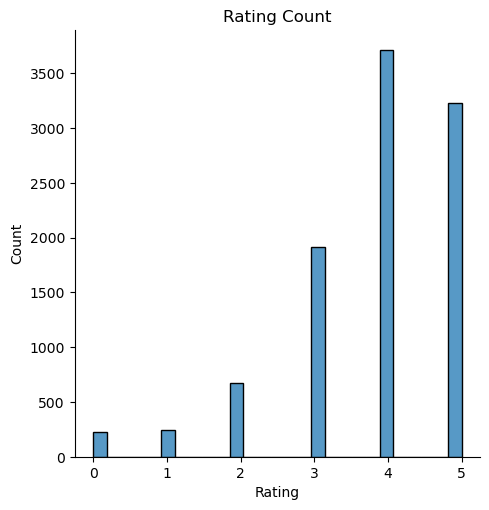

In [27]:
sns.displot(book_reviews, x = 'rating')
plt.title('Rating Count')
plt.xlabel('Rating')

### Word Clouds

In [28]:
from wordcloud import WordCloud, STOPWORDS

In [29]:
text = " ".join(review for review in book_reviews['review_text'])

In [30]:
wordcloud = WordCloud(background_color = 'white').generate(text)

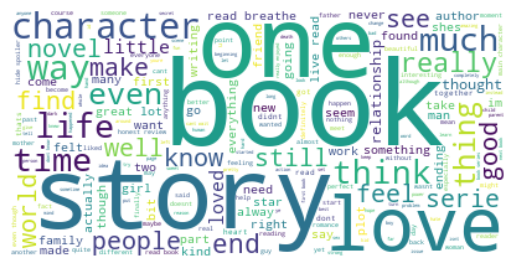

In [31]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Removing stopwords (words that bring essentially no meaning)

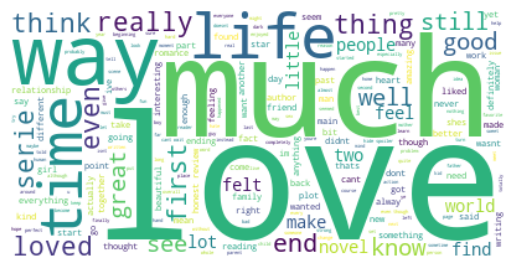

In [32]:
stopwords = set(STOPWORDS)
stopwords.update(["story", "read", "book", "one", "wa", "ha", "character"])
wordcloud2 = WordCloud(stopwords = stopwords, background_color = 'white').generate(text)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis

In [33]:
word_id = dict(zip(words, range(len(words))))
word_set = set(words)

In [34]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum.lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[word_id[w]] += 1
    feat.append(1) # offset
    return feat

In [35]:
X = [feature(d) for d in book_reviews['review_text']]
y = book_reviews['rating']

In [36]:
# Regularized regression
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
predictions = clf.predict(X)

In [37]:
pos_word = list(zip(theta[:-1], words))
pos_word.sort()
pos_word[-20:]

[(0.15480964308048747, 'tear'),
 (0.1559041470570222, 'wow'),
 (0.15612248602815523, 'amazing'),
 (0.15875456786653946, 'adore'),
 (0.1611621495966505, 'partner'),
 (0.16709103255551888, 'fascinating'),
 (0.168948653810493, 'brilliant'),
 (0.16922161449509618, 'social'),
 (0.17358157069730099, 'laugh'),
 (0.17780109531749091, 'cry'),
 (0.17963727916961794, 'youve'),
 (0.18770875965831532, 'wait'),
 (0.19587954765552096, 'ride'),
 (0.19892543766583748, 'glad'),
 (0.24683825269848142, 'awesome'),
 (0.2549487963715371, 'fantastic'),
 (0.26591067548366737, 'excellent'),
 (0.30867631547077695, '5'),
 (0.35140980717293313, 'reread'),
 (0.37975800347694416, '45')]

In [38]:
neg_word = list(zip(theta[:-1], words))
neg_word.sort()
neg_word[:20]

[(-0.3138709901609646, 'boring'),
 (-0.2984049805718574, 'premise'),
 (-0.26319980790592623, 'cover'),
 (-0.26003221393739884, 'ok'),
 (-0.2592209624522002, 'tried'),
 (-0.25698942315126, 'awful'),
 (-0.23198257260342828, 'sentence'),
 (-0.22929838811990225, 'twitter'),
 (-0.21254225023981385, 'potential'),
 (-0.20760892014724636, 'annoying'),
 (-0.2069274929463198, 'none'),
 (-0.20369857472095873, '35'),
 (-0.19738703105841243, 'rating'),
 (-0.19629225897898847, 'concept'),
 (-0.19426670239762736, 'supposed'),
 (-0.18920260259584312, 'forget'),
 (-0.1800809899344313, 'library'),
 (-0.17880862147108084, 'flat'),
 (-0.17174702048904594, 'sound'),
 (-0.1694714534190334, 'hoping')]

### N-grams

In [39]:
def feature2(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum.lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
    for w in ws + ws2 + ws3 + ws4 + ws5:
        if w in words:
            feat[word_id[w]] += 1
    feat.append(1) #offset
    return feat

In [40]:
X = [feature2(d) for d in book_reviews['review_text']]
y = book_reviews['rating']

In [41]:
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
predictions = clf.predict(X)

In [42]:
pos_word = list(zip(theta[:-1], words))
pos_word.sort()
pos_word[-20:]

[(0.15480964308048747, 'tear'),
 (0.1559041470570222, 'wow'),
 (0.15612248602815523, 'amazing'),
 (0.15875456786653946, 'adore'),
 (0.1611621495966505, 'partner'),
 (0.16709103255551888, 'fascinating'),
 (0.168948653810493, 'brilliant'),
 (0.16922161449509618, 'social'),
 (0.17358157069730099, 'laugh'),
 (0.17780109531749091, 'cry'),
 (0.17963727916961794, 'youve'),
 (0.18770875965831532, 'wait'),
 (0.19587954765552096, 'ride'),
 (0.19892543766583748, 'glad'),
 (0.24683825269848142, 'awesome'),
 (0.2549487963715371, 'fantastic'),
 (0.26591067548366737, 'excellent'),
 (0.30867631547077695, '5'),
 (0.35140980717293313, 'reread'),
 (0.37975800347694416, '45')]

## TF-IDF

Example Review

In [43]:
example = book_reviews['review_text'][8]
example

'another hard put nonfiction book erik larson really enjoyed book mostly learn submarine warfare wwi also learn history time america entered war importance shipping england ruthlessness autonomy german uboat commander larson also great job layering interesting historical info though overdid little bit one drama story lusitania larson focus british wanted lusitania sunk help draw america war conclusion seems case though isnt conclusive evidence lusitania sank american died war hundred american boat sank definitely helped change america attitude even took 2 year sank america troop arrive likely explanation indeed plot however imperfect endanger lusitania order involve united state war favorite detail book simply took navigate uboat ww1 instance day sonar submarine traveled utterly blind trusting entirely accuracy sea chart one great fear uboat men halfsunk derelict uncharted rock might lie path crazy plus torpedo weigh 3 thousand pound boat could carry 7 failure rate something like 60 al

Document Frequency

In [44]:
df = defaultdict(int)
for d in book_reviews['review_text']:
    r = ''.join([c for c in d.lower() if not c in punctuation])
    for w in set(r.split()):
        df[w] += 1

Term Frequency

In [45]:
import math

tf = defaultdict(int)
r = ''.join([c for c in example.lower() if not c in punctuation])
for w in r.split():
    # Note = rather than +=, different versions of tf could be used instead
    tf[w] = 1
    
tfidf = dict(zip(words,[tf[w] * math.log2(len(book_reviews) / df[w]) for w in words]))
tfidfQuery = [tf[w] * math.log2(len(book_reviews) / df[w]) for w in words]

In [46]:
maxTf = [(tf[w],w) for w in words]
maxTf.sort(reverse=True)
maxTfIdf = [(tfidf[w],w) for w in words]
maxTfIdf.sort(reverse=True)
maxTfIdf[:10]

[(6.2991719550683785, 'american'),
 (6.27662938641729, 'rock'),
 (6.1079475518256094, 'respect'),
 (6.0881842970041795, 'helped'),
 (6.011732236566306, 'entirely'),
 (5.984075893663441, 'path'),
 (5.984075893663441, 'dangerous'),
 (5.870004126954646, 'died'),
 (5.756475181324232, 'state'),
 (5.725614217619471, 'lie')]

Calculating cosine similarity in respect to TF-IDF results

In [47]:
def cosine_similarity(x1, x2):
    numer = 0
    norm1 = 0
    norm2 = 0
    for a1,a2 in zip(x1,x2):
        numer += a1*a2
        norm1 += a1**2
        norm2 += a2**2
    if norm1*norm2:
        return numer / math.sqrt(norm1*norm2)
    return 0

In [53]:
similarities = []
for review in book_reviews['review_text']:
    tf = defaultdict(int)
    r = ''.join([c for c in review.lower() if not c in punctuation])
    for w in r.split():
        # Note = rather than +=
        tf[w] = 1
    tfidf2 = [tf[w] * math.log2(len(book_reviews) / df[w]) for w in words]
    similarities.append((cosine_similarity(tfidfQuery, tfidf2), review))

In [54]:
similarities.sort(reverse=True)
similarities[:5]

[(1.0,
  'another hard put nonfiction book erik larson really enjoyed book mostly learn submarine warfare wwi also learn history time america entered war importance shipping england ruthlessness autonomy german uboat commander larson also great job layering interesting historical info though overdid little bit one drama story lusitania larson focus british wanted lusitania sunk help draw america war conclusion seems case though isnt conclusive evidence lusitania sank american died war hundred american boat sank definitely helped change america attitude even took 2 year sank america troop arrive likely explanation indeed plot however imperfect endanger lusitania order involve united state war favorite detail book simply took navigate uboat ww1 instance day sonar submarine traveled utterly blind trusting entirely accuracy sea chart one great fear uboat men halfsunk derelict uncharted rock might lie path crazy plus torpedo weigh 3 thousand pound boat could carry 7 failure rate something l

## Sentence Transformers

In [65]:
from sentence_transformers import SentenceTransformer

st = SentenceTransformer("all-MiniLM-L6-v2")

Example sentence transformers

In [ ]:
# different nlp concepts
# sentiment analysis (applying existing model)
# topic extraction/nlp topic modeling/classification
# embedding = classifcation tasks
# features: years, rating, genre
# concatendate features

In [ ]:
# streamlit app: recommendation based on genre
# llms to generate summary?? of book or book review
# cosine distance between two books, return top 5 closest books (would have to merge with book information dataset)
# predicting rating = latent factor model